In [1]:
# import warnings filter 
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Importing Dask packages
import dask.dataframe as dd
import dask.array as da

#import otheer needed python packages
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import os
import wget

# Extracting the dataset online

### To overwrite the previous datasets when re-running
if 'covid19_data.csv' in os.listdir("../data"):
    os.remove('/home/qwerty/Documents/COVID19-time-series-analysis/data/covid19_data.csv')
    path = '/home/qwerty/Documents/COVID19-time-series-analysis/data/covid19_data.csv'
    url =  "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv"
    wget.download(url, path)
else:
    path = '/home/qwerty/Documents/COVID19-time-series-analysis/data/covid19_data.csv'
    url =  "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv"
    wget.download(url, path)
    
# Reading the dataset
data = dd.read_csv('../data/covid19_data.csv',
                   dtype={'Confirmed': 'float64','Deaths': 'float64', 'Lat':'float64', 'long':'float64'})

### Preprocessing the datasets

In [3]:
data.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
1,2020-01-23,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2,2020-01-24,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
3,2020-01-25,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
4,2020-01-26,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0


In [4]:
data.compute().shape

(30972, 8)

In [5]:
data.compute().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30972 entries, 0 to 30971
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            30972 non-null  object 
 1   Country/Region  30972 non-null  object 
 2   Province/State  9512 non-null   object 
 3   Lat             30972 non-null  float64
 4   Long            30972 non-null  float64
 5   Confirmed       30856 non-null  float64
 6   Recovered       29348 non-null  float64
 7   Deaths          30856 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.9+ MB


In [6]:
#Parsing the 'Date' feature to a date datatype 
data['Date'] = dd.to_datetime(data['Date'], infer_datetime_format=True) 

In [7]:
data.compute().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30972 entries, 0 to 30971
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            30972 non-null  datetime64[ns]
 1   Country/Region  30972 non-null  object        
 2   Province/State  9512 non-null   object        
 3   Lat             30972 non-null  float64       
 4   Long            30972 non-null  float64       
 5   Confirmed       30856 non-null  float64       
 6   Recovered       29348 non-null  float64       
 7   Deaths          30856 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 1.9+ MB


In [8]:
# Checking for missing values
data.isnull().sum().compute()

Date                  0
Country/Region        0
Province/State    21460
Lat                   0
Long                  0
Confirmed           116
Recovered          1624
Deaths              116
dtype: int64

In [9]:
#Query the features sections with missing values to understand it

# Using the "COnfirmed" feature as case study
data.loc[data['Confirmed'].isnull()].compute()

### This can be done to the other features in the dataset with missing values

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
5916,2020-01-22,Canada,Recovery aggregated,56.1304,-106.3468,NaN,0.0,NaN
5917,2020-01-23,Canada,Recovery aggregated,56.1304,-106.3468,NaN,0.0,NaN
5918,2020-01-24,Canada,Recovery aggregated,56.1304,-106.3468,NaN,0.0,NaN
5919,2020-01-25,Canada,Recovery aggregated,56.1304,-106.3468,NaN,0.0,NaN
5920,2020-01-26,Canada,Recovery aggregated,56.1304,-106.3468,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...
6027,2020-05-12,Canada,Recovery aggregated,56.1304,-106.3468,NaN,34055.0,NaN
6028,2020-05-13,Canada,Recovery aggregated,56.1304,-106.3468,NaN,35177.0,NaN
6029,2020-05-14,Canada,Recovery aggregated,56.1304,-106.3468,NaN,36104.0,NaN
6030,2020-05-15,Canada,Recovery aggregated,56.1304,-106.3468,NaN,36908.0,NaN


In [10]:
# Query the data with relevant features
dataset = data[['Date','Country/Region',
                   'Confirmed', 'Deaths', 'Recovered']]

In [11]:
dataset.head()

,Date,Country/Region,Confirmed,Deaths,Recovered
0,2020-01-22,Afghanistan,0.0,0.0,0.0
1,2020-01-23,Afghanistan,0.0,0.0,0.0
2,2020-01-24,Afghanistan,0.0,0.0,0.0
3,2020-01-25,Afghanistan,0.0,0.0,0.0
4,2020-01-26,Afghanistan,0.0,0.0,0.0


In [12]:
datewise_df = dataset.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [13]:
datewise_df.head()

,Confirmed,Recovered,Deaths
Date,,,
2020-01-22,555.0,28.0,17.0
2020-01-23,654.0,30.0,18.0
2020-01-24,941.0,36.0,26.0
2020-01-25,1434.0,39.0,42.0
2020-01-26,2118.0,52.0,56.0


In [14]:
nic = len(dataset["Country/Region"].unique())
cfm_cases = datewise_df["Confirmed"].compute().iloc[-1]
rec = datewise_df["Recovered"].compute().iloc[-1]
deaths = datewise_df["Deaths"].compute().iloc[-1]
active_cases = cfm_cases - rec- deaths
closed_cases = rec + deaths

In [15]:
def overview():
    print('=== COVID-19 Global Overview ===')
    print(f'== Number of countries which infected:{nic} ==')
    print(f'== Total num of confirmed cases:{cfm_cases} ==')
    print(f'== Total num of recovered cases:{rec} ==')
    print(f'== Total num of deaths:{deaths}')
    print(f'== Total num of Active cases around the world:{active_cases} ==')
    print(f'== Total num of Closed cases around the world:{closed_cases} ==')
    
overview()

=== COVID-19 Global Overview ===
== Number of countries which infected:188 ==
== Total num of confirmed cases:4634068.0 ==
== Total num of recovered cases:1693197.0 ==
== Total num of deaths:311781.0
== Total num of Active cases around the world:2629090.0 ==
== Total num of Closed cases around the world:2004978.0 ==


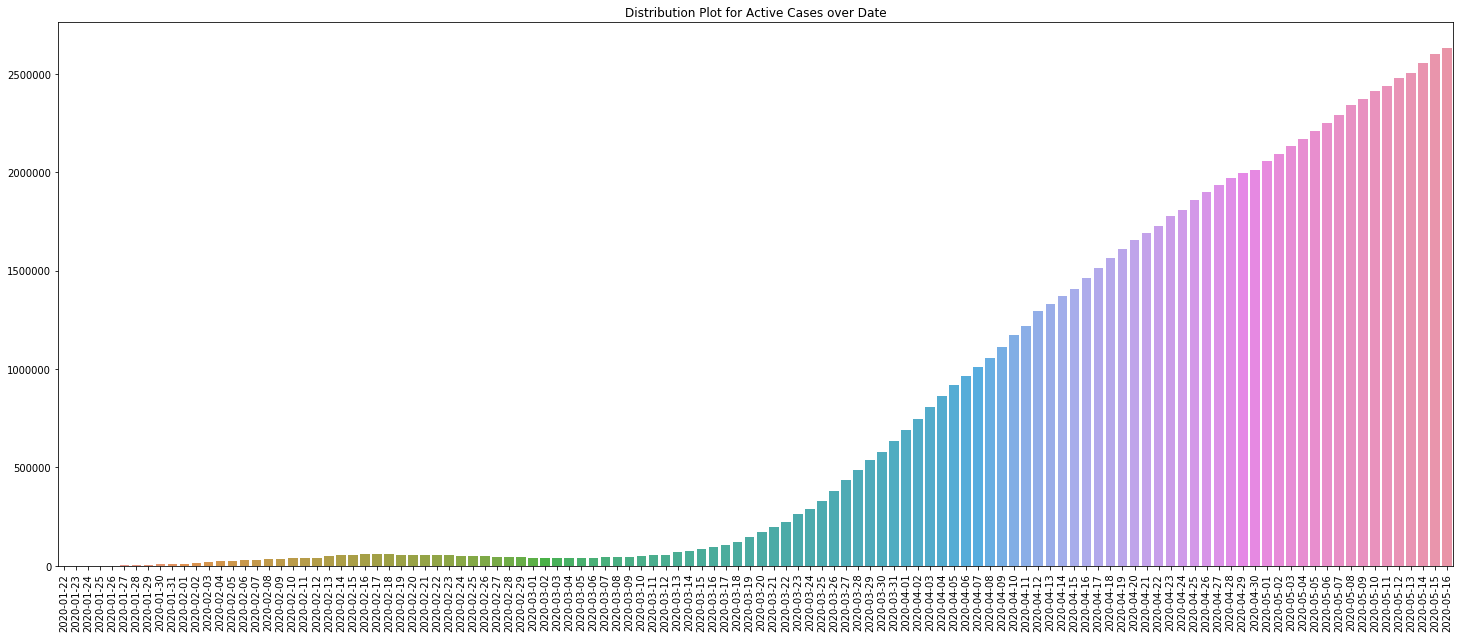

In [16]:
# Plotting the distribution on active cases
plt.figure(figsize=(25,10))
sns.barplot(x=datewise_df.compute().index.date, y = datewise_df["Confirmed"].compute()-
            datewise_df["Recovered"].compute()-datewise_df["Deaths"].compute())
plt.title("Distribution Plot for Active Cases over Date")
plt.xticks(rotation=90)
plt.savefig('../figures/Active Cases Cases over Date.png');

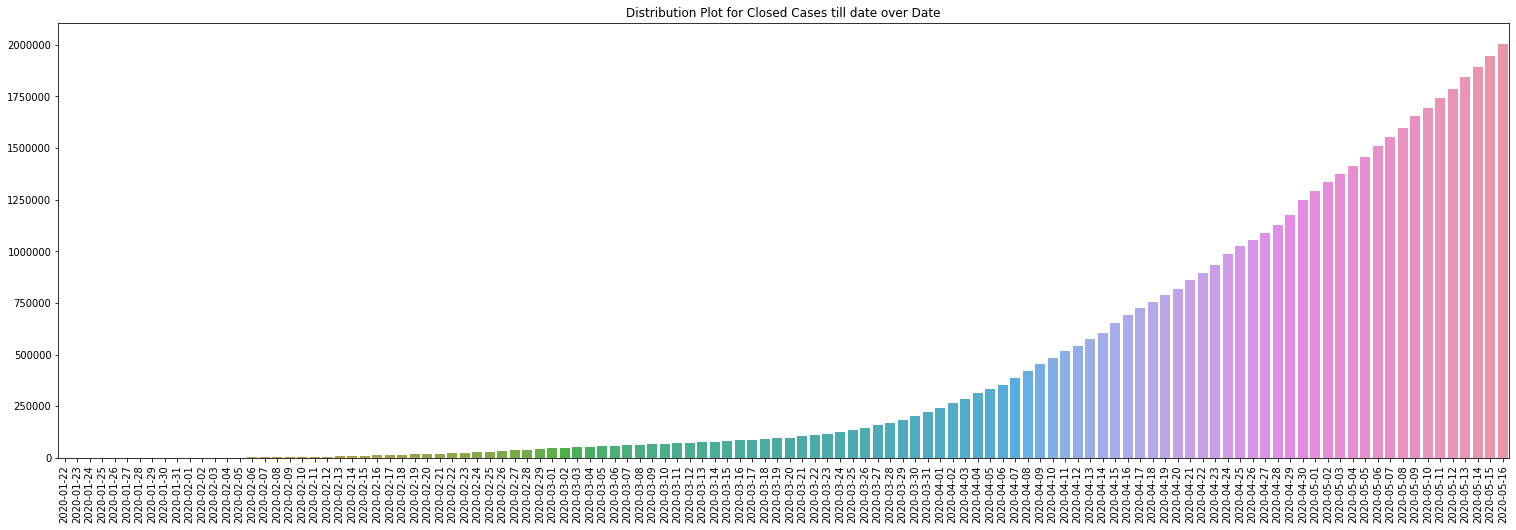

In [17]:
# Plotting distribution of closed cases
plt.figure(figsize=(26,8))
sns.barplot(x=datewise_df.compute().index.date, y = datewise_df["Recovered"].compute() + 
            datewise_df["Deaths"].compute())
plt.xticks(rotation=90)
plt.title("Distribution Plot for Closed Cases till date over Date")
plt.savefig('../figures/Closed Cases Cases over Date.png');

In [18]:
woy = datewise_df.compute().index.weekofyear
datewise_df = datewise_df.compute()
datewise_df["WeekOfYear"] = woy

In [19]:
datewise_df.head()

,Confirmed,Recovered,Deaths,WeekOfYear
Date,,,,
2020-01-22,555.0,28.0,17.0,4
2020-01-23,654.0,30.0,18.0,4
2020-01-24,941.0,36.0,26.0,4
2020-01-25,1434.0,39.0,42.0,4
2020-01-26,2118.0,52.0,56.0,4


In [20]:
week_num=[]
weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]
counter=1
for i in list(datewise_df["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise_df[datewise_df["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    weekwise_recovered.append(datewise_df[datewise_df["WeekOfYear"]==i]["Recovered"].iloc[-1])
    weekwise_deaths.append(datewise_df[datewise_df["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num.append(counter)
    counter=counter+1

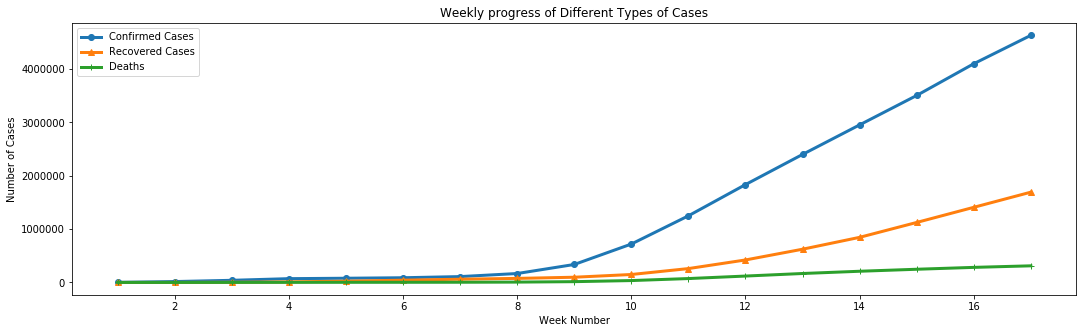

In [21]:
plt.figure(figsize=(18,5))
plt.plot(week_num,weekwise_confirmed,linewidth=3,marker="o", label='Confirmed Cases')
plt.plot(week_num,weekwise_recovered,linewidth=3,marker="^", label='Recovered Cases')
plt.plot(week_num,weekwise_deaths,linewidth=3,marker="+", label='Deaths')
plt.ylabel("Number of Cases")
plt.xlabel("Week Number")
plt.title("Weekly progress of Different Types of Cases")
plt.legend()
plt.savefig('../figures/Weekly progress of Different Types of Cases.png');

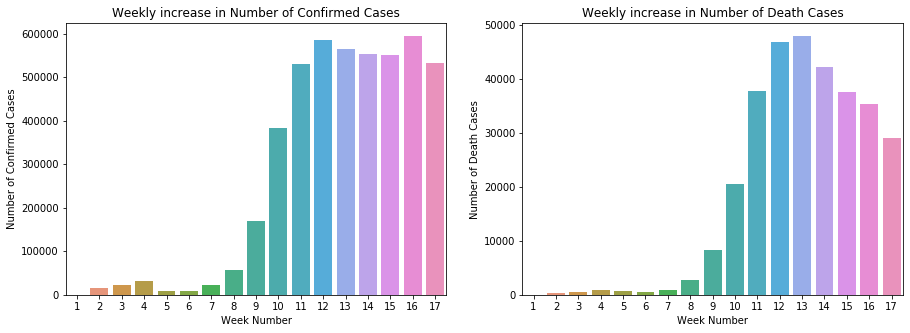

In [22]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.barplot(x=week_num,y=pd.Series(weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num,y=pd.Series(weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("Weekly increase in Number of Confirmed Cases")
ax2.set_title("Weekly increase in Number of Death Cases")
plt.savefig('../figures/Weekly increase.png');

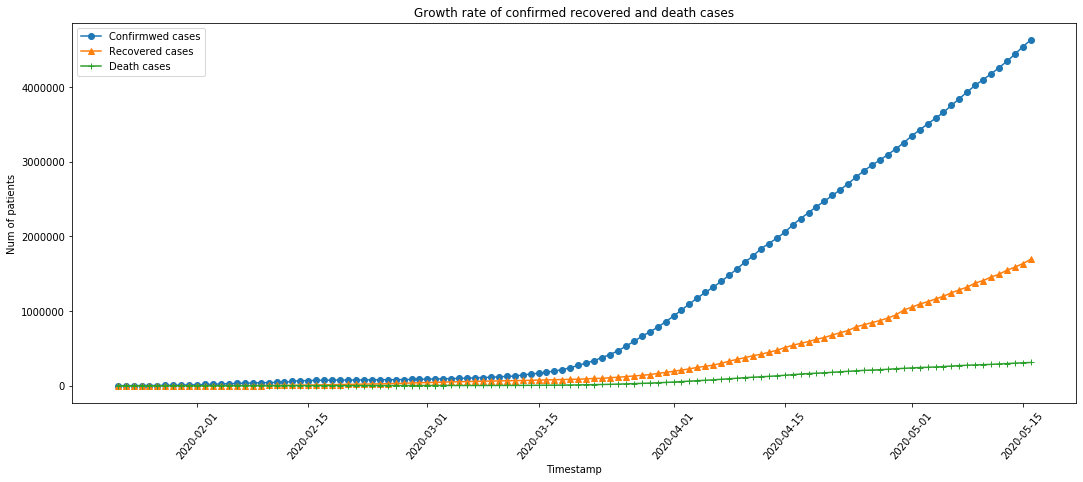

In [23]:
plt.figure(figsize=(18,7))
plt.plot(datewise_df["Confirmed"],marker="o",label="Confirmwed cases")
plt.plot(datewise_df["Recovered"],marker="^",label="Recovered cases")
plt.plot(datewise_df["Deaths"],marker="+",label="Death cases")
plt.xticks(rotation="50")
plt.ylabel("Num of patients")
plt.xlabel("Timestamp")
plt.title("Growth rate of confirmed recovered and death cases")
plt.legend()
plt.savefig('../figures/Growth rate.png');

In [24]:
#Calculating the Mortality Rate and Recovery Rate
datewise_df["Mortality Rate"] = (datewise_df["Deaths"]/datewise_df["Confirmed"])*100 
datewise_df["Recovery Rate"] = (datewise_df["Recovered"]/datewise_df["Confirmed"])*100 
datewise_df["Active Cases"] = (datewise_df["Confirmed"]-datewise_df["Recovered"]-datewise_df["Deaths"]) 
datewise_df["Closed Cases"] = (datewise_df["Deaths"]+datewise_df["Recovered"])

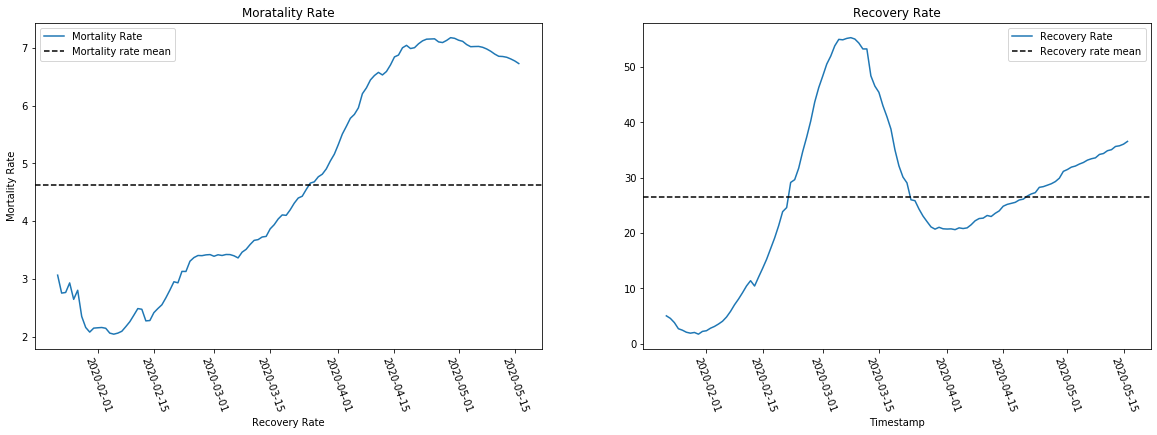

In [25]:
# ploting mortality and Recovery rate
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,6))
ax1.plot(datewise_df["Mortality Rate"],label="Mortality Rate")
ax2.plot(datewise_df["Recovery Rate"],label="Recovery Rate")
ax1.set_title("Moratality Rate")
ax2.set_title("Recovery Rate")
ax1.set_xlabel("Timestamp")
ax2.set_xlabel("Timestamp")
ax1.set_ylabel("Mortality Rate")
ax1.set_xlabel("Recovery Rate")
for tick in ax1.get_xticklabels():
    tick.set_rotation(-70)
for tick in ax2.get_xticklabels():
    tick.set_rotation(-70)
ax1.axhline(datewise_df["Mortality Rate"].mean(),label="Mortality rate mean", linestyle="--", color='black')
ax2.axhline(datewise_df["Recovery Rate"].mean(),label="Recovery rate mean", linestyle="--", color='black')
ax2.legend()
ax1.legend()
plt.savefig('../figures/Mortality and Recovery rate.png');

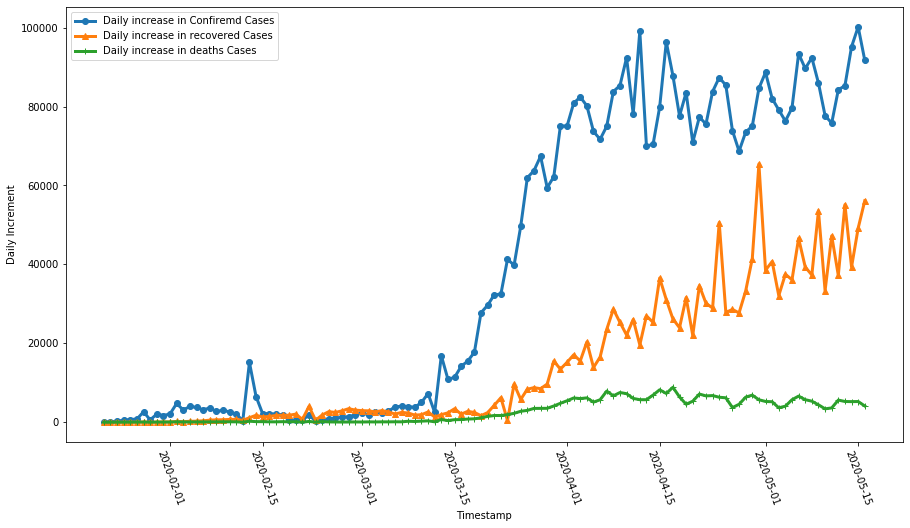

In [26]:
plt.figure(figsize=(15,8))
plt.plot(datewise_df["Confirmed"].diff().fillna(0),label="Daily increase in Confiremd Cases",
         linewidth=3,marker="o")
plt.plot(datewise_df["Recovered"].diff().fillna(0),label="Daily increase in recovered Cases",
         linewidth=3,marker="^")
plt.plot(datewise_df["Deaths"].diff().fillna(0),label="Daily increase in deaths Cases",linewidth=3,marker="+")
plt.legend()
plt.xticks(rotation=-70)
plt.ylabel("Daily Increment")
plt.xlabel("Timestamp")
plt.savefig('../figures/Daily increment.png');

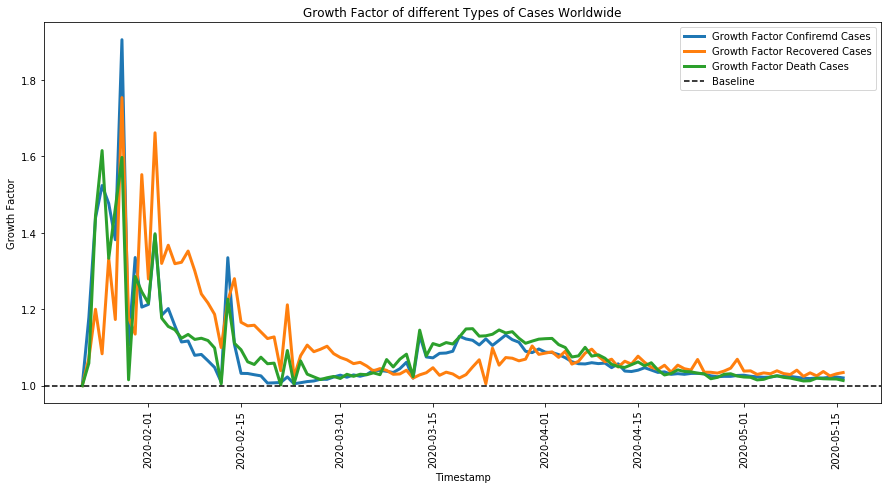

In [27]:
daily_increase_confirm=[]
daily_increase_recovered=[]
daily_increase_deaths=[]
for i in range(datewise_df.shape[0]-1):
    daily_increase_confirm.append(((datewise_df["Confirmed"].iloc[i+1]/datewise_df["Confirmed"].iloc[i])))
    daily_increase_recovered.append(((datewise_df["Recovered"].iloc[i+1]/datewise_df["Recovered"].iloc[i])))
    daily_increase_deaths.append(((datewise_df["Deaths"].iloc[i+1]/datewise_df["Deaths"].iloc[i])))
daily_increase_confirm.insert(0,1)
daily_increase_recovered.insert(0,1)
daily_increase_deaths.insert(0,1)

plt.figure(figsize=(15,7))
plt.plot(datewise_df.index,daily_increase_confirm,label="Growth Factor Confiremd Cases",linewidth=3)
plt.plot(datewise_df.index,daily_increase_recovered,label="Growth Factor Recovered Cases",linewidth=3)
plt.plot(datewise_df.index,daily_increase_deaths,label="Growth Factor Death Cases",linewidth=3)
plt.xlabel("Timestamp")
plt.ylabel("Growth Factor")
plt.title("Growth Factor of different Types of Cases Worldwide")
plt.axhline(1,linestyle='--',color='black',label="Baseline")
plt.xticks(rotation=90)
plt.legend()
plt.savefig('../figures/Growth factor.png');

### Country wise Analysis

In [28]:
countrywise_df = data[data["Date"]==data["Date"].max()].groupby(["Country/Region"]).agg({
    "Confirmed":"sum","Recovered":"sum","Deaths":"sum", "Lat": "min", "Long": "min"})

countrywise_df["Mortality"]=(countrywise_df["Deaths"]/countrywise_df["Confirmed"])*100
countrywise_df["Recovery"]=(countrywise_df["Recovered"]/countrywise_df["Confirmed"])*100

In [29]:
countrywise_df.head()

,Confirmed,Recovered,Deaths,Lat,Long,Mortality,Recovery
Country/Region,,,,,,,
Afghanistan,6402.0,745.0,168.0,33.0000,65.0000,2.624180,11.636988
Albania,933.0,714.0,31.0,41.1533,20.1683,3.322615,76.527331
Algeria,6821.0,3409.0,542.0,28.0339,1.6596,7.946049,49.978009
Andorra,761.0,615.0,51.0,42.5063,1.5218,6.701708,80.814717
Angola,48.0,17.0,2.0,-11.2027,17.8739,4.166667,35.416667


In [30]:
top_15_confirmed= countrywise_df.Confirmed.nlargest(15).reset_index().compute()
top_15_deaths = countrywise_df.Deaths.nlargest(15).reset_index().compute()
top_15_confirmed = dd.from_pandas(top_15_confirmed, npartitions=1)
top_15_deaths = dd.from_pandas(top_15_deaths, npartitions=1)

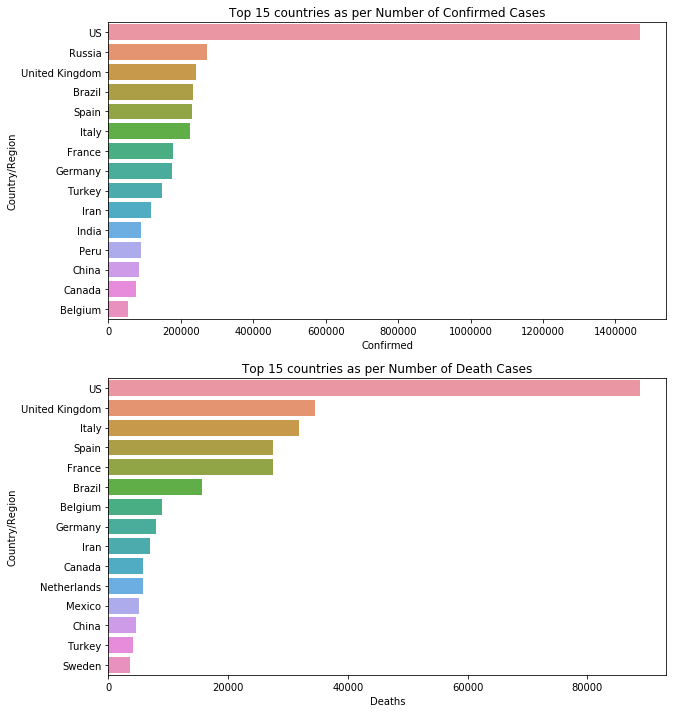

In [31]:
fig, (ax1,ax2) = plt.subplots(2, 1 ,figsize=(10,   12))
sns.barplot(x=top_15_confirmed["Confirmed"].compute(),y=top_15_confirmed["Country/Region"].compute(),ax=ax1)
ax1.set_title("Top 15 countries as per Number of Confirmed Cases")
sns.barplot(x=top_15_deaths["Deaths"].compute(),y=top_15_deaths["Country/Region"].compute(),ax=ax2)
ax2.set_title("Top 15 countries as per Number of Death Cases")
plt.savefig('../figures/Top 15 countries confirmed-Death.png');

In [32]:
countrywise_df["Active_Cases"] = countrywise_df["Confirmed"] - (countrywise_df["Deaths"] +
                                                                countrywise_df["Recovered"])

In [33]:
top_15_active = countrywise_df.Active_Cases.nlargest(15).reset_index().compute()
top_15_active = dd.from_pandas(top_15_active, npartitions=1)

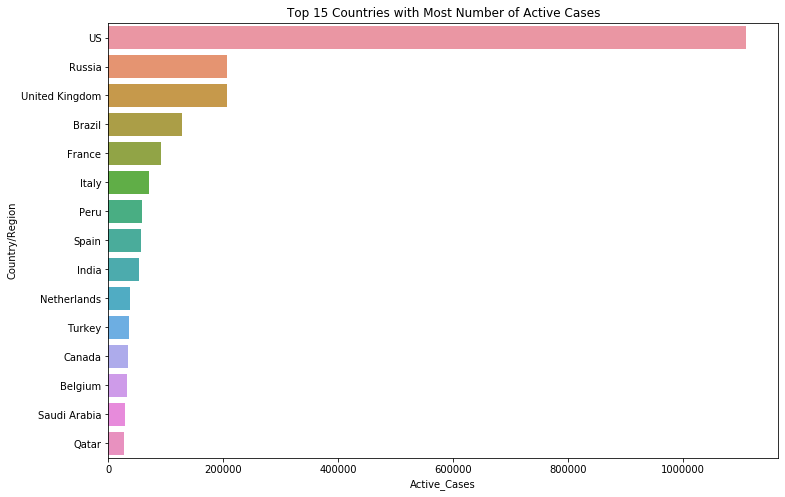

In [34]:
plt.figure(figsize=(12,8))
sns.barplot(x = top_15_active["Active_Cases"].compute(), y = top_15_active["Country/Region"].compute())
plt.title("Top 15 Countries with Most Number of Active Cases")
plt.savefig('../figures/Top 15 Active Cases.png');

In [35]:
plot_mortality_rate = countrywise_df[countrywise_df["Confirmed"] > 500]
plot_mortality_rate = plot_mortality_rate.Mortality.nlargest(15).reset_index().compute()
plot_mortality_rate = dd.from_pandas(plot_mortality_rate, npartitions=1)
plot_recovery_rate = countrywise_df[countrywise_df["Confirmed"] > 500]
plot_recovery_rate = plot_recovery_rate.Recovered.nlargest(15).reset_index().compute()
plot_recovery_rate = dd.from_pandas(plot_recovery_rate, npartitions=1)

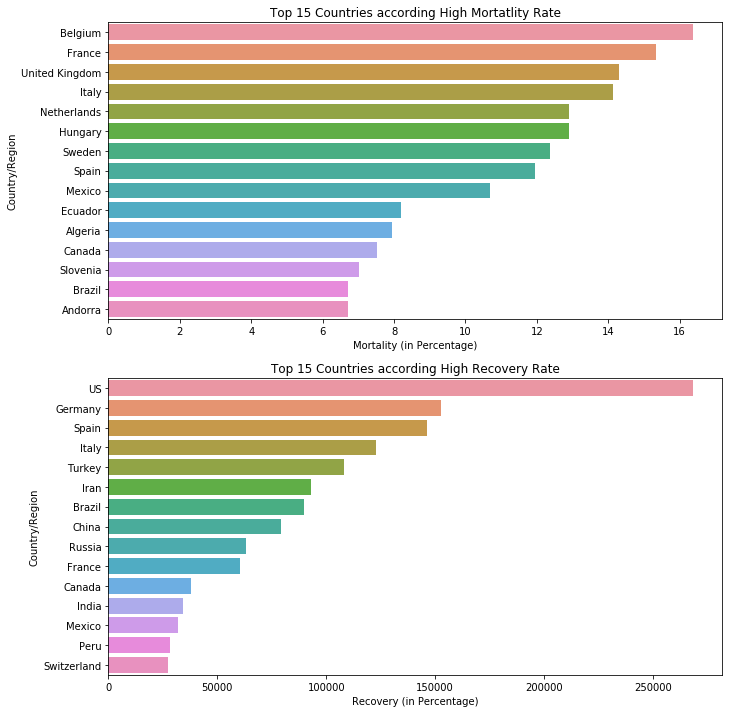

In [36]:
fig, (ax1,ax2) = plt.subplots(2, 1 , figsize = (11, 12))
sns.barplot(x  = plot_mortality_rate["Mortality"].compute(),y = plot_mortality_rate["Country/Region"].compute(), ax = ax1)
sns.barplot(x  = plot_recovery_rate["Recovered"].compute(),y = plot_recovery_rate["Country/Region"].compute(), ax = ax2)
ax1.set_title("Top 15 Countries according High Mortatlity Rate")
ax1.set_xlabel("Mortality (in Percentage)")
ax2.set_title("Top 15 Countries according High Recovery Rate")
ax2.set_xlabel("Recovery (in Percentage)")
plt.savefig('../figures/Top 15 Mortality and Recovery.png');

In [38]:
countrywise_df["Survival_Probability"]=(1-(countrywise_df["Deaths"]/countrywise_df["Confirmed"]))*100
top_25_survival=countrywise_df[countrywise_df["Confirmed"]>1000]
top_25_survival=top_25_survival.Survival_Probability.nlargest(15).reset_index().compute()
top_25_survival=dd.from_pandas(top_25_survival, npartitions=1)

In [40]:
top_25_survival.head()

,Country/Region,Survival_Probability
0,Qatar,99.951569
1,Singapore,99.919579
2,Bahrain,99.822143
3,Djibouti,99.699474
4,Maldives,99.628942


In [50]:
bottom_15_survival=countrywise_df[countrywise_df["Confirmed"]>100]
bottom_15_survival=bottom_15_survival.Survival_Probability.nlargest(15).reset_index().compute()

Mean Survival Probability across all countries dd.Scalar<series-..., dtype=float64>
Mean Death Probability across all countries dd.Scalar<sub-c0e..., dtype=float64>


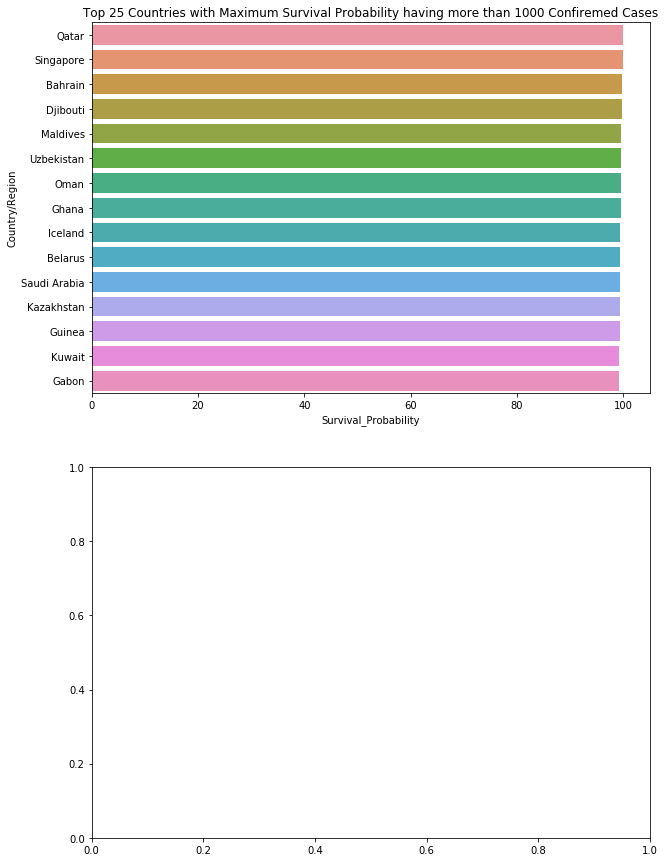

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
sns.barplot(x=top_25_survival["Survival_Probability"].compute(),y=top_25_survival["Country/Region"].compute(),ax=ax1)
ax1.set_title("Top 25 Countries with Maximum Survival Probability having more than 1000 Confiremed Cases")
sns.barplot(x=bottom_15_survival["Survival Probability"],y=bottom_15_survival["Country/Region"],ax=ax2)
plt.title("Bottom 15 Countries as per Survival Probability")
plt.savefig('../figures/top 25 Survival.png');

In [ ]:
print('Mean Survival Probability across all countries',countrywise_df["Survival_Probability"].mean())
print('Mean Death Probability across all countries',100-countrywise_df["Survival_Probability"].mean())
